# CNN Training for the image -> sensors prediction (Hybrid architecture)

64x64x3 -> 20 vector of sensoric values (angle and track lidar sensor)

VUT FIT 2022
Master thesis - Application of Reinforcement Learning in Autonomous Driving

David Vosol (xvosol00)

In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import (
    Dataset,
    DataLoader,
)

print(torch.__version__)

1.11.0+cu113


## Importing the Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#DVO dataset


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
      self.len = 0
      with open(root_dir, 'rb') as pkl:
        try:
          self.dataset_dict = pickle.load(pkl)
          self.labels = torch.stack(self.dataset_dict['labels']).squeeze(1)
          self.images = torch.stack(self.dataset_dict['data']).squeeze(1)

          self.len += len(self.dataset_dict['labels'])  
          print( len(self.dataset_dict['labels']) )

          while True:
            
            self.dataset_dict = pickle.load(pkl)
            
            self.labels = torch.cat( ( self.labels, torch.stack(self.dataset_dict['labels']).squeeze(1) ) )
            self.images = torch.cat( ( self.images, torch.stack(self.dataset_dict['data']).squeeze(1) ) )
            self.len += len(self.dataset_dict['labels'])
            
            print('total_size:: ', self.len)
            print( len(self.dataset_dict['labels']) )
        
        except EOFError:
          print('dataset was read')
          print('total_size:: ', self.len)

        print('labels shape:: ', self.labels.shape)
        print('images shape:: ', self.images.shape)
        print('images[0].shape:: ', self.images[0].shape)

        
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return self.len

    def __getitem__(self, index):

        image = self.images[index]
        label = self.labels[index]
        
        #already normalized 
        if self.transform:
            image = self.transform(image)

        return (image, label)




In [ ]:
# Hyperparameters
# in_channel = 3
# num_classes = 2
# num_epochs = 10
learning_rate = 1e-3
batch_size = 32


# Load Data
dataset = CustomDataset(
    root_dir='/content/drive/MyDrive/DAVID/DP/models/pickled_samples_nn_128_rwd2_snrs_eroad.pkl',
    transform=None, #transforms.ToTensor()
)



#Loading the dataset
# train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


In [ ]:
#Loading the dataset

train_size = int(np.ceil(( dataset.__len__() ) * 8.0 / 10))
test_size = int(np.floor((dataset.__len__() ) * 2.0 / 10))

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))


train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


print(train_set[0])

(tensor([[[0.3686, 0.3725, 0.3765,  ..., 0.3843, 0.3804, 0.3765],
         [0.3725, 0.3725, 0.3765,  ..., 0.3843, 0.3765, 0.3804],
         [0.3725, 0.3725, 0.3765,  ..., 0.3765, 0.3765, 0.3804],
         ...,
         [0.6314, 0.6353, 0.6275,  ..., 0.5569, 0.5608, 0.5686],
         [0.6392, 0.6275, 0.6196,  ..., 0.5412, 0.5451, 0.5490],
         [0.5922, 0.5843, 0.5725,  ..., 0.5216, 0.5294, 0.5333]],

        [[0.3686, 0.3725, 0.3765,  ..., 0.3843, 0.3804, 0.3765],
         [0.3725, 0.3725, 0.3765,  ..., 0.3843, 0.3765, 0.3804],
         [0.3725, 0.3725, 0.3765,  ..., 0.3765, 0.3765, 0.3804],
         ...,
         [0.6745, 0.6784, 0.6784,  ..., 0.6863, 0.6902, 0.6980],
         [0.6980, 0.6941, 0.6863,  ..., 0.6706, 0.6745, 0.6824],
         [0.6824, 0.6745, 0.6706,  ..., 0.6549, 0.6588, 0.6667]],

        [[0.3569, 0.3608, 0.3647,  ..., 0.3725, 0.3686, 0.3647],
         [0.3608, 0.3608, 0.3647,  ..., 0.3686, 0.3647, 0.3686],
         [0.3608, 0.3608, 0.3647,  ..., 0.3647, 0.3647, 0

In [ ]:
print(train_set[0][1])
print(train_set[1][1])
print(train_set[2][1])

tensor([ 0.0162,  0.0682,  0.1082,  0.1262,  0.1419,  0.1546,  0.1625,  0.1673,
         0.1719,  0.1754,  0.1792,  0.1833,  0.1877,  0.1946,  0.2038,  0.2269,
         0.4611,  0.4177,  0.3356,  0.0430, -0.1128])
tensor([-0.0126,  0.0680,  0.0970,  0.1101,  0.1214,  0.1289,  0.1329,  0.1351,
         0.1371,  0.1385,  0.1400,  0.1414,  0.1429,  0.1450,  0.1475,  0.1521,
         0.1620,  0.1796,  0.2082,  0.0423, -0.1978])
tensor([-0.0137,  0.0506,  0.4542,  0.3521,  0.2880,  0.2542,  0.2387,  0.2309,
         0.2243,  0.2196,  0.2151,  0.2107,  0.2064,  0.2006,  0.1942,  0.1828,
         0.1627,  0.1359,  0.1091,  0.0621,  0.0412])


In [ ]:
print(dataset.images[9008][0][39])

tensor([0.1255, 0.2471, 0.3059, 0.3882, 0.2431, 0.2275, 0.2314, 0.2392, 0.2392,
        0.2275, 0.2353, 0.2314, 0.2157, 0.2314, 0.2392, 0.2431, 0.2275, 0.2275,
        0.2314, 0.2392, 0.2353, 0.2314, 0.2275, 0.2314, 0.2275, 0.2275, 0.2275,
        0.2275, 0.2353, 0.2353, 0.2275, 0.2275, 0.2353, 0.2353, 0.2353, 0.2353,
        0.2314, 0.2353, 0.2353, 0.2353, 0.2314, 0.2314, 0.2275, 0.2353, 0.2275,
        0.2275, 0.2275, 0.2353, 0.2275, 0.2314, 0.2314, 0.2353, 0.2314, 0.2353,
        0.2235, 0.2510, 0.2627, 0.2706, 0.2863, 0.3098, 0.4275, 0.5294, 0.3882,
        0.1765])


## The Data
visual example - does not matter that the image is inverted, it is the same during the TORCS experiments.

The agent does not care, as long as it is the same everywhere

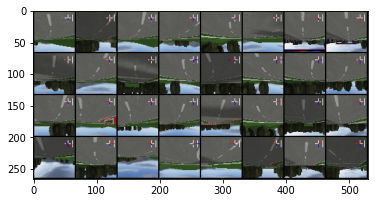

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

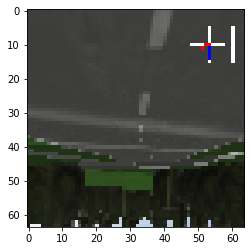

In [ ]:
img_ = dataset.images[3060]

imshow(img_)

Dimensions of a batch.

In [ ]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32, 21])


## The Model


In [ ]:
class CnnToSensors(nn.Module):
    def __init__(self):
        super(CnnToSensors, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
        self.pool2 = nn.AvgPool2d(2, 2) 
        self.conv11 = nn.Conv2d(6, 12, 5, 1, 2)
        self.pool4 = nn.AvgPool2d(2, 2)
        self.conv2= nn.Conv2d(12, 24, 5, 1, 2)
        # self.pool44 = nn.AvgPool2d(2, 2)
        # if img_num == 2:
        #     self.fc2 = nn.Linear(1344, hidden_cnn)
        # else:
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, labels[0].shape[-1])

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv11(x)))
        x = self.pool4(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Testing the model with 1 batch to ensure that the output dimensions are correct

In [ ]:
## test the model with 1 batch
model = CnnToSensors()
for images, labels in train_loader:
    print("batch size:", images.shape)
    out = model(images)
    # print(out.shape)
    break

batch size: torch.Size([32, 3, 64, 64])


## Training hyperparameters

In [ ]:
learning_rate = 0.001
num_epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CnnToSensors()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The Accuracy performance measure

In [ ]:
import numpy as np

def get_percentage_diff(previous, current, BATCH_SIZE):
    try:
        percentage = abs(previous - current)/((previous + current)/2) *100
    except ZeroDivisionError:
        percentage = float('inf')
    return abs(percentage).mean() #/ BATCH_SIZE
    
a = np.array([[1.23,0.3],[0.25,-0.18]])
b = np.array([[1.05,0.5],[0.85,-1.08]])

diff = get_percentage_diff(a,b, 2)

print(diff)

79.43438140806562


# **Training session**

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_percentage_diff(labels, logits, batch_size)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f' \
          %(epoch, train_running_loss / i))

    print( 'Acc::', train_acc/i )    

    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_percentage_diff(labels, outputs, batch_size)
        
    print('Test Accuracy::', test_acc/i )

    #Saving the model every 5 epochs
    if epoch % 5 == 0:
      torch.save(model, 'model_cnn_to_sensors-eroad.pth')

Epoch: 0 | Loss: 0.0148
Acc:: tensor(109.4200, device='cuda:0', grad_fn=<DivBackward0>)
Test Accuracy:: tensor(63.8059, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 | Loss: 0.0094
Acc:: tensor(81.5989, device='cuda:0', grad_fn=<DivBackward0>)
Test Accuracy:: tensor(84.8596, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 | Loss: 0.0074
Acc:: tensor(71.6302, device='cuda:0', grad_fn=<DivBackward0>)
Test Accuracy:: tensor(128.6772, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 3 | Loss: 0.0069
Acc:: tensor(65.3477, device='cuda:0', grad_fn=<DivBackward0>)
Test Accuracy:: tensor(379.4256, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 4 | Loss: 0.0065
Acc:: tensor(49.0876, device='cuda:0', grad_fn=<DivBackward0>)
Test Accuracy:: tensor(58.0128, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 5 | Loss: 0.0062
Acc:: tensor(54.0782, device='cuda:0', grad_fn=<DivBackward0>)
Test Accuracy:: tensor(48.4972, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 6 | Loss: 0.0060
Acc:: tensor(

computation of the accuracy on the testing dataset to see how well the model performs

In [ ]:
torch.save(model, 'model_cnn_to_sensors-eroad_final.pth')

test_acc = 0.0
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_percentage_diff(labels, outputs, batch_size)
    print('Example:: ', i)
    print(labels[i])
    print(outputs[i])
        
print('Test Accuracy: %.2f'%( test_acc/i))